In [32]:
import keras
import tensorflow.keras.models

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import model_from_json

import pandas as pd
import numpy as np
import pandas_ta as ta

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import os
import sys

path_to_data = os.path.join("..", "ProcessingData", "BTC Minute CSVs", "BTCUSER_all_processed.parquet")
df = pd.read_parquet(path_to_data, engine='fastparquet')

indexes = [i for i in range(0, len(df)) if i % (30) == 0]
temp = df.iloc[indexes]
temp = temp.loc[df['Date'] > '2019-06-01 00:00:00']
df = temp

def calculate_rsi(df: pd.DataFrame, length: int = 14):
    if not isinstance(length, int):
        raise Exception("length must be an integer!")
    df[f'RSI_{length}'] = ta.rsi(df['Close'], length=length)


def calculate_sma(df: pd.DataFrame, length: int = 50):
    """
    Wrapper function for sma
    :param df:
    :param length:
    :return:
    """
    if not isinstance(length, int):
        raise Exception("length must be an integer!")
    df[f'SMA_{length}'] = ta.sma(df['Close'], length=length)


def calculate_macd(df: pd.DataFrame, fast: int = 12, slow: int = 26, signal: int = 9):
    """
    Wrapper function for MACD
    :param df:
    :param fast:
    :param slow:
    :param signal:
    :return:
    """
    if not isinstance(fast, int):
        raise Exception("fast must be an integer!")
    if not isinstance(slow, int):
        raise Exception("slow must be an integer!")
    if not isinstance(signal, int):
        raise Exception("signal must be an integer!")
    df[f'MACD_{fast}_{slow}_{signal}'] = ta.macd(close=df['Close'], fast=fast, slow=slow, signal=signal)[
        f'MACD_{fast}_{slow}_{signal}']


rsi_length = 14
sma_length = 50
macd_length_fast, macd_length_slow, macd_length_signal = 12, 26, 9

calculate_rsi(df, length=rsi_length)
calculate_sma(df, length=sma_length)
calculate_macd(df, fast=macd_length_fast, slow=macd_length_slow, signal=macd_length_signal)
non_nan = max(rsi_length, sma_length, macd_length_slow, macd_length_fast, macd_length_signal)
df = df[non_nan:]
feature_columns = ['Close', f'RSI_{rsi_length}', f'SMA_{sma_length}',
                   f'MACD_{macd_length_fast}_{macd_length_slow}_{macd_length_signal}']


def create_scaler_for_feature(df, feature):
    data_values = df[feature].astype('float32')
    train_scl = data_values[0:int(len(data_values) * 0.80)]
    scl = MinMaxScaler()

    scl.fit(train_scl.values.reshape(-1, 1))
    return scl


scalers = dict()
for feature in feature_columns:
    scalers[feature] = create_scaler_for_feature(df, feature)
data = df[:]
features_values = []
for feature in feature_columns:
    feature_values = df[feature].astype('float32')
    feature_values = scalers[feature].transform(feature_values.values.reshape(-1, 1))
    features_values.append(np.copy(feature_values))
features_values


def process_data(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb):
        X.append(data[i:(i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)


lb = 40
X_data = []
Y_data = []
for feature in features_values:
    X, Y = process_data(feature, lb)
    X_data.append(np.copy(X))
    Y_data.append(np.copy(Y))
#concatenating the lines
X_full, Y_full = X_data[0], Y_data[0]
#separating into test and train
split = 0.8
X_train, X_test = X_full[:int(X_full.shape[0] * split)], X_full[int(X_full.shape[0] * split):]
Y_train, Y_test = Y_full[:int(Y_full.shape[0] * split)], Y_full[int(Y_full.shape[0] * split):]

In [33]:
model = keras.models.load_model('Models\\model_all_stuff_0')

In [34]:
Xt = model.predict(X_test)
Xt.shape

(8400, 1)

Text(0.5, 1.0, 'Train Dataset')

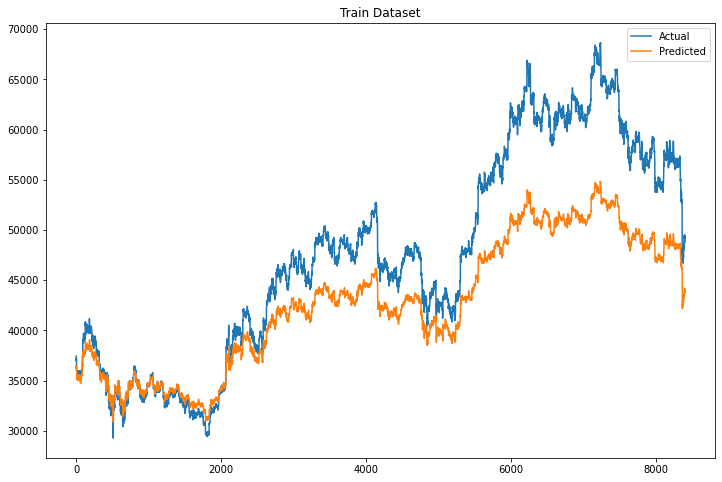

In [35]:
plt.figure(figsize=(12,8))

Xt = model.predict(X_test)
plt.plot(scalers['Close'].inverse_transform(Y_test.reshape(-1,1)), label="Actual")
plt.plot(scalers['Close'].inverse_transform(Xt.reshape(-1, 1)), label="Predicted")
plt.legend()
plt.title("Train Dataset")